# Project 2

For this project, I am going to build classification models to predict if a person is diabetic or not given certain features. My main goal for this project is to understand various classification algorithms on a deeper level and be able to compare them.

## Data Inspection


In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import scipy.stats as stats


In [2]:
# read data
data = pd.read_csv('/content/diabetes_binary_5050split_health_indicators_BRFSS2015.csv')

In [3]:
# inspect shape, columns, nulls, datatypes
data.shape

(70692, 22)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70692 non-null  float64
 1   HighBP                70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   Stroke                70692 non-null  float64
 7   HeartDiseaseorAttack  70692 non-null  float64
 8   PhysActivity          70692 non-null  float64
 9   Fruits                70692 non-null  float64
 10  Veggies               70692 non-null  float64
 11  HvyAlcoholConsump     70692 non-null  float64
 12  AnyHealthcare         70692 non-null  float64
 13  NoDocbcCost           70692 non-null  float64
 14  GenHlth               70692 non-null  float64
 15  MentHlth           

There are no nulls so that is great.

In [5]:
data.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


After inpsecting the data, I see that there are 2 types of variables in the dataset: categorical and numerical variables. So, instead of calculating correlation normally, I will need to use Cramer's V to calculate the correlation between each of the categorical value with the target and point biserial between the numerical value with the target.

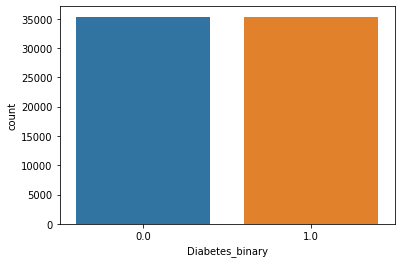

In [6]:
# Check see if data is balanced
ax = sns.countplot(x="Diabetes_binary", data=data)

In [7]:
data['Diabetes_binary'].value_counts()

0.0    35346
1.0    35346
Name: Diabetes_binary, dtype: int64

Data is perfectly balanced.


## Preprocessing - Calculating Correlation

First, I will calculate the correlation between numerical data and categorical data using Point Biserial. A result of 1 means there is a positive correlation, 0 means there is no correlation, and -1 means there is a negative correlation.

In [8]:
# calculate point-biserial correlation between BMI and target
x = data['Diabetes_binary'].to_numpy()
y = data['BMI'].to_numpy()
stats.pointbiserialr(x, y)

PointbiserialrResult(correlation=0.29337274476104624, pvalue=0.0)

In [9]:
# similarly, correlation between target and mental health days
x = data['Diabetes_binary'].to_numpy()
y = data['MentHlth'].to_numpy()
stats.pointbiserialr(x, y)

PointbiserialrResult(correlation=0.08702877147509541, pvalue=6.795439709628024e-119)

In [10]:
# correlation between target and days with physical illness or injury
x = data['Diabetes_binary'].to_numpy()
y = data['PhysHlth'].to_numpy()
stats.pointbiserialr(x, y)

PointbiserialrResult(correlation=0.21308101903810778, pvalue=0.0)

Since the p-value of all 3 correlations are less than .05, they are statistically significant. 

Now I will use Cramer's V to calculate correlation between the categorical variables. A result of 1 means highly associated, 0 means not.

In [11]:
# define cramers_v function
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [12]:
# New dataframe with only categorical values
data2 = data.copy()
data2 = data2.drop(columns=['BMI', 'MentHlth', 'PhysHlth'])
data2

,Diabetes_binary,HighBP,HighChol,CholCheck,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,8.0,5.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70687,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,0.0,0.0,6.0,4.0,1.0
70688,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,1.0,1.0,10.0,3.0,6.0
70689,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,5.0,1.0,0.0,13.0,6.0,4.0
70690,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,0.0,11.0,2.0,4.0


In [13]:
# Make empty dataframe
df_cramers = pd.DataFrame(index = data2.columns, columns = data2.columns)
# Use the function above to calculate cramers_v
for col in df_cramers.columns:
    for row in df_cramers.index:
        df_cramers[col][row] = cramers_v(data2[col], data2[row])

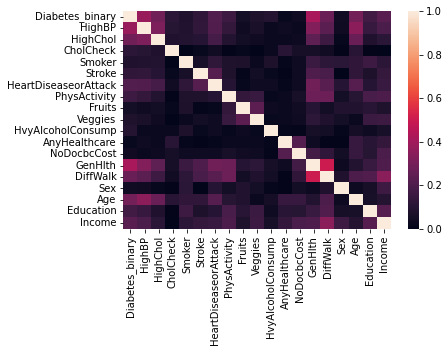

In [14]:
# Visualize it
sns.heatmap(df_cramers.astype(float))

In [15]:
df_cramers

,Diabetes_binary,HighBP,HighChol,CholCheck,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,DiffWalk,Sex,Age,Education,Income
Diabetes_binary,0.999972,0.381471,0.289162,0.11523,0.085889,0.125313,0.211452,0.158591,0.053917,0.07917,0.094709,0.022815,0.040755,0.417135,0.272589,0.044225,0.295364,0.173472,0.233325
HighBP,0.381471,0.999971,0.316466,0.103124,0.087329,0.128947,0.210678,0.13602,0.04065,0.066483,0.026696,0.035497,0.0262,0.328611,0.234723,0.040617,0.34953,0.144578,0.198216
HighChol,0.289162,0.316466,0.999972,0.085808,0.093295,0.099657,0.181109,0.090345,0.047205,0.042636,0.025093,0.031238,0.032937,0.24258,0.161968,0.016882,0.271031,0.084759,0.111766
CholCheck,0.11523,0.103124,0.085808,0.999707,0.001956,0.022022,0.043206,0.00723,0.016876,0.0,0.026657,0.106515,0.0624,0.061656,0.044166,0.006947,0.108023,0.007366,0.0
Smoker,0.085889,0.087329,0.093295,0.001956,0.999972,0.064491,0.124322,0.079704,0.074688,0.029654,0.077675,0.012309,0.035552,0.152524,0.119698,0.112034,0.126877,0.164007,0.115921
Stroke,0.125313,0.128947,0.099657,0.022022,0.064491,0.999879,0.223281,0.079833,0.008106,0.047381,0.022944,0.005107,0.035902,0.203748,0.192163,0.000128,0.125096,0.076245,0.137563
HeartDiseaseorAttack,0.211452,0.210678,0.181109,0.043206,0.124322,0.223281,0.999944,0.098108,0.019027,0.036071,0.03684,0.015131,0.035763,0.287309,0.232536,0.09805,0.225598,0.097944,0.149964
PhysActivity,0.158591,0.13602,0.090345,0.00723,0.079704,0.079833,0.098108,0.999966,0.133729,0.149238,0.018659,0.026751,0.063137,0.277149,0.276809,0.051585,0.104097,0.194184,0.202555
Fruits,0.053917,0.04065,0.047205,0.016876,0.074688,0.008106,0.019027,0.133729,0.99997,0.238542,0.03296,0.029073,0.045638,0.099937,0.050612,0.088615,0.086784,0.105919,0.080944
Veggies,0.07917,0.066483,0.042636,0.0,0.029654,0.047381,0.036071,0.149238,0.238542,0.999958,0.021681,0.028825,0.036896,0.117293,0.083948,0.052435,0.025875,0.154883,0.156458


I will drop several variables that have very low correlation with the target: Smoker, Fruits, Veggies, HvyAlcoholConsump, AnyHealthcare, NoDocbcCost, Sex as Cramer V's values below 0.1 indicate no to very weak relationship. This also helps with the model's performance.

In [16]:
data = data.drop(columns=['Smoker', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'Sex'])

In [17]:
data

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Stroke,HeartDiseaseorAttack,PhysActivity,GenHlth,MentHlth,PhysHlth,DiffWalk,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,3.0,5.0,30.0,0.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,0.0,10.0,0.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,0.0,0.0,1.0,3.0,0.0,3.0,0.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,8.0,5.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70687,1.0,0.0,1.0,1.0,37.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,6.0,4.0,1.0
70688,1.0,0.0,1.0,1.0,29.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,10.0,3.0,6.0
70689,1.0,1.0,1.0,1.0,25.0,0.0,1.0,0.0,5.0,15.0,0.0,1.0,13.0,6.0,4.0
70690,1.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,11.0,2.0,4.0


## Modeling

1. **Random Forest**



Random Forest is an ensemble method for classification using multiple decision trees. I am going to use Random Forest because it is useful for application where accuracy matters and it is suitable for large data sets. It is good for both discrete and continuous variables. Preprocessing is also quite easy. 

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
# split data into test and train
# drop target from X and save the target to y
X = data.drop('Diabetes_binary', axis = 1)
y = data['Diabetes_binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(49484, 14)
(49484,)
(21208, 14)
(21208,)


In [20]:
from sklearn.ensemble import RandomForestClassifier


In [21]:
# build random forest model
rf = RandomForestClassifier(random_state = 1, max_features = 'sqrt', n_jobs = 1, verbose = 1)
# train the model
%time rf.fit(X_train, y_train)
# mean accuracy on test data and labels
rf.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: user 4.55 s, sys: 167 ms, total: 4.72 s
Wall time: 4.72 s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished


0.7290173519426631

In [22]:
# get the predictions
y_pred = rf.predict(X_test)
print(y_pred)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[1. 0. 0. ... 0. 0. 1.]


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished


Now I am going to evaluate the model with confusion matrix, accuracy, precision, recall and F1 score.

In [23]:
from sklearn import metrics

[[7249 3232]
 [2515 8212]]


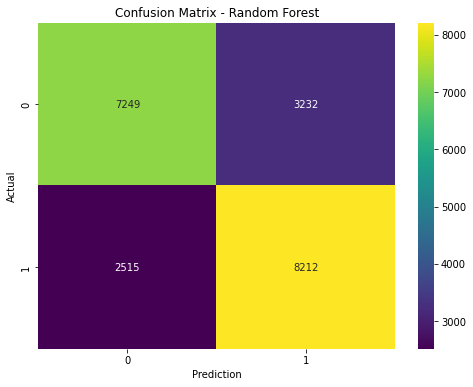

In [24]:
# confusion matrix to evaluate model
matrix_rf = metrics.confusion_matrix(y_test, y_pred)
print(matrix_rf)

# heatmap matrix
plt.figure(figsize = (8,6))
sns.heatmap(matrix_rf, annot = True, fmt = ".0f", cmap = 'viridis')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

In [25]:
# RF classification report
report_rf = metrics.classification_report(y_test, y_pred)
print(report_rf)


              precision    recall  f1-score   support

         0.0       0.74      0.69      0.72     10481
         1.0       0.72      0.77      0.74     10727

    accuracy                           0.73     21208
   macro avg       0.73      0.73      0.73     21208
weighted avg       0.73      0.73      0.73     21208



From the graph, we have 8212 TP, 7249 TN, 2515 FN, and 3232 FP. False Negatives in this case would be bad, since the model predicts people to be healthy but they actually have diabetes. Because we care about reducing the False Negatives, the most important metric is Recall. 

Recall value of 70% means that 3 of every 10 diabetic people in reality are missed by this model and 7 labeled as diabetic.

2. **Naive Bayes**

Now I am going to test a different ML algorithm: Naive Bayes. This assumes that the variables are independent of each other. I decided to use this because this is fairly simple and works well with a large data set.
I will use Gaussian NB for continuous and Multinomial NB for discrete variables, and combine the two. 

In [26]:
from sklearn.naive_bayes import CategoricalNB

In [27]:
# build a Gaussian Classifier
cnb = CategoricalNB()
# train the model 
%time cnb.fit(X_train, y_train)
# get the predictions
y_pred = cnb.predict(X_test)

CPU times: user 39.7 ms, sys: 0 ns, total: 39.7 ms
Wall time: 44 ms


[[7771 2710]
 [2793 7934]]


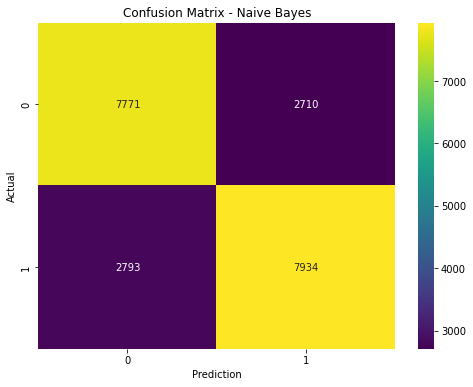

In [28]:
# confusion matrix to evaluate model
matrix_nb = metrics.confusion_matrix(y_test, y_pred)
print(matrix_nb)

# heatmap matrix
plt.figure(figsize = (8,6))
sns.heatmap(matrix_nb, annot = True, fmt = ".0f", cmap = 'viridis')
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

In [29]:
# NB classification report
report_nb = metrics.classification_report(y_test, y_pred)
print(report_nb)


              precision    recall  f1-score   support

         0.0       0.74      0.74      0.74     10481
         1.0       0.75      0.74      0.74     10727

    accuracy                           0.74     21208
   macro avg       0.74      0.74      0.74     21208
weighted avg       0.74      0.74      0.74     21208



3. 

## Evaluation